TABLE :

In [ ]:
from CreateTable import create_df
import matplotlib.pyplot as plt
import numpy as np
data = create_df()  # It is possible to round the positions without loosing any important information

GRID PLOT

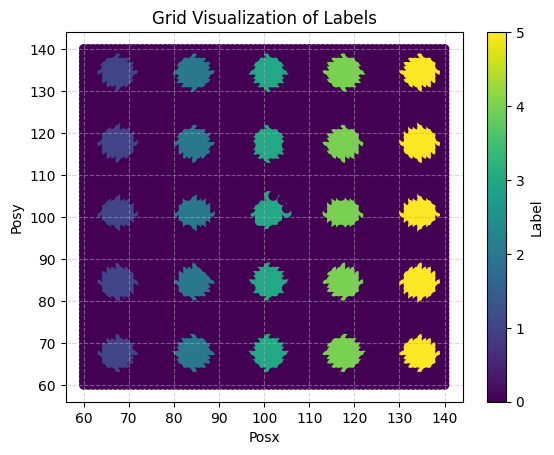

In [5]:
# Scatter plot with color based on the label
plt.scatter(data["posx"], data["posy"], c=data["label"], cmap="viridis")

# Grid and labels
plt.grid(True, linestyle="--", alpha=0.5)
plt.xlabel("Posx")
plt.ylabel("Posy")
plt.title("Grid Visualization of Labels")
plt.colorbar(label="Label")

plt.show()

PLOT OF A CYCLE

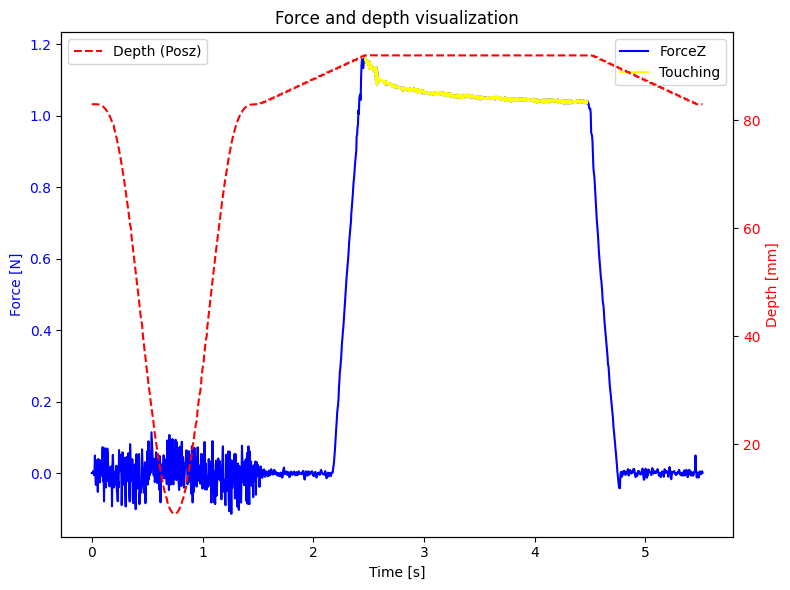

In [3]:
df = data.sample(1) # Picks a random row
posz_t = [pos for mask, pos in zip(df['Touching'].tolist()[0], df['posz'].tolist()[0]) if mask]
fz_t =  [f for mask, f in zip(df['Touching'].tolist()[0], df['Fz'].tolist()[0]) if mask]
t_touching = [f for mask, f in zip(df['Touching'].tolist()[0], df['t'].tolist()[0]) if mask]

fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.plot(df['t'].tolist()[0], df['Fz'].tolist()[0], label="ForceZ", color="blue", linestyle="-")
ax1.plot(t_touching, fz_t, color="yellow",label="Touching", linestyle="-")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Force [N]", color="blue")  # Replace with actual label
ax1.tick_params(axis="y", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(df['t'].tolist()[0], df['posz'].tolist()[0], label="Depth (Posz)", color="red", linestyle="--")
ax2.set_ylabel("Depth [mm]", color="red")  # Replace with actual label
ax2.tick_params(axis="y", labelcolor="red")

plt.title("Force and depth visualization")
fig.tight_layout()
ax1.legend()
ax2.legend()
plt.show()

AFTER SMOOTHING (these are the signals that are used to extract the features)

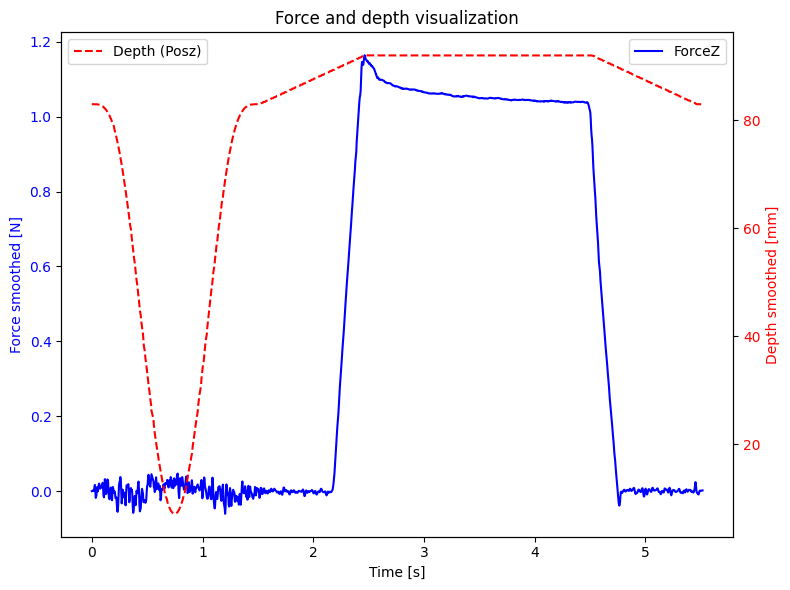

In [4]:
fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.plot(df['t'].tolist()[0], df['Fz_s'].tolist()[0], label="ForceZ", color="blue", linestyle="-")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Force smoothed [N]", color="blue")  # Replace with actual label
ax1.tick_params(axis="y", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(df['t'].tolist()[0], df['posz_s'].tolist()[0], label="Depth (Posz)", color="red", linestyle="--")
ax2.set_ylabel("Depth smoothed [mm]", color="red")  # Replace with actual label
ax2.tick_params(axis="y", labelcolor="red")

plt.title("Force and depth visualization")
fig.tight_layout()
ax1.legend()
ax2.legend()
plt.show()

POWER SPECTRAL DENSITY

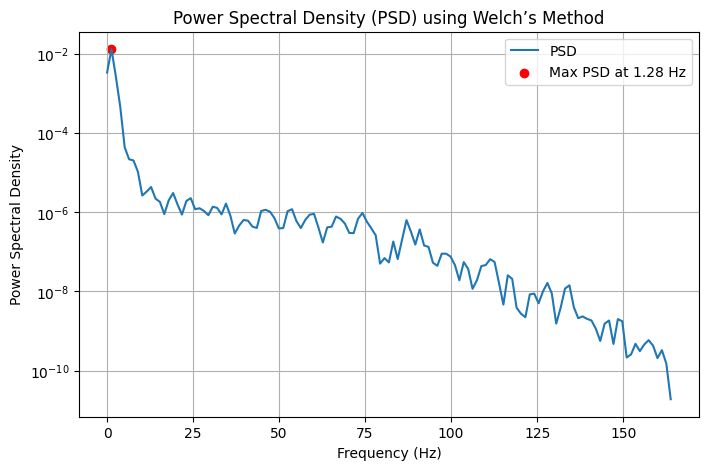

In [5]:
from scipy.signal import welch
df = data.sample(1) # Picks another random row
fs = 1/np.mean(np.diff(df['t'].tolist()[0]))
freqs, psd = welch(df['Fz_s'].tolist()[0], fs=fs)
psd_max_freq = freqs[np.argmax(psd)]  # Dominant frequency in the psd

# Plot PSD
plt.figure(figsize=(8, 5))
plt.semilogy(freqs, psd, label='PSD')
plt.scatter(psd_max_freq, np.max(psd), color='red', label=f'Max PSD at {psd_max_freq:.2f} Hz')

# Labels and title
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title('Power Spectral Density (PSD) using Welch’s Method')
plt.legend()
plt.grid(True)
plt.show()

DISTRIBUTION OF FEATURES ACROSS DIFFERENT LABEL

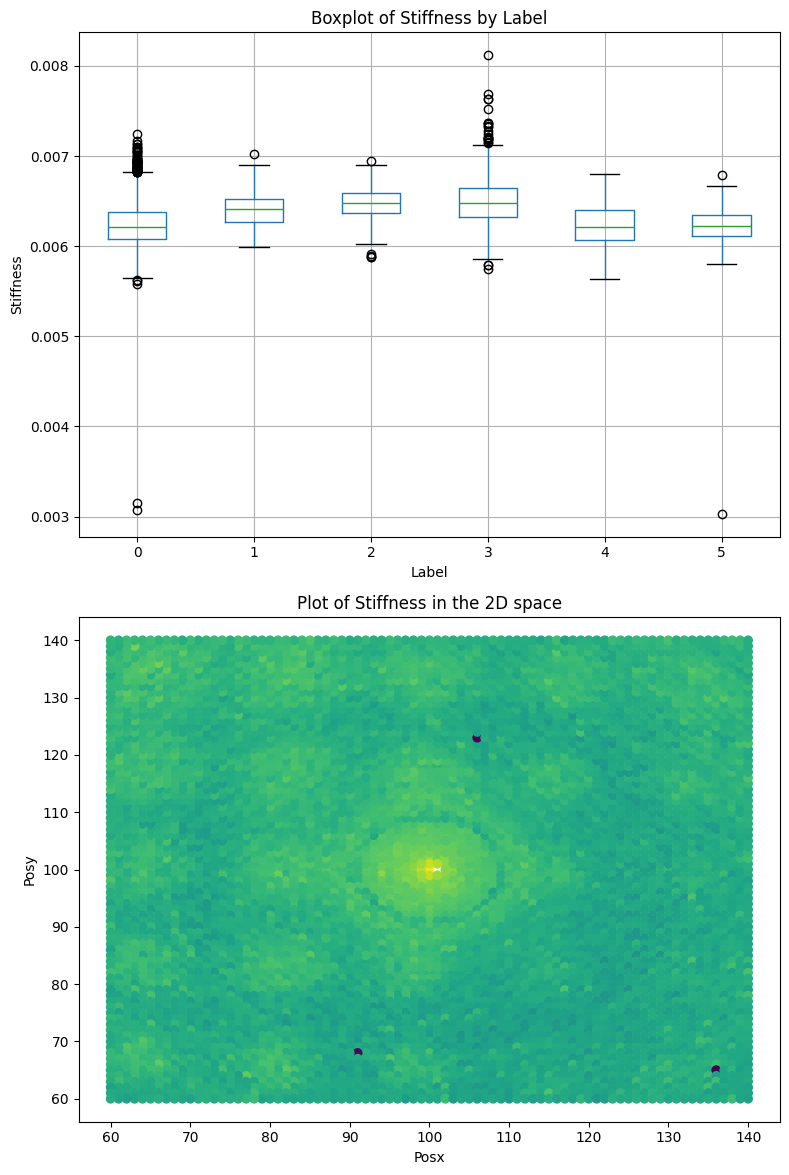

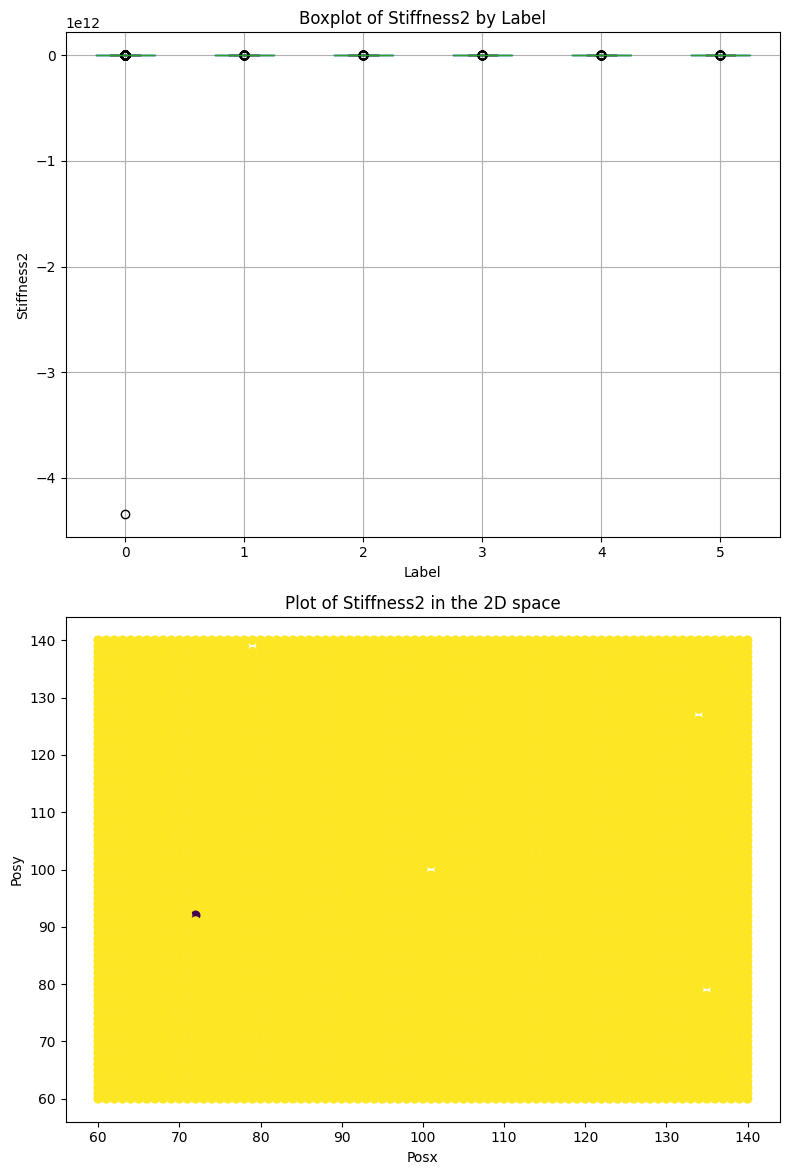

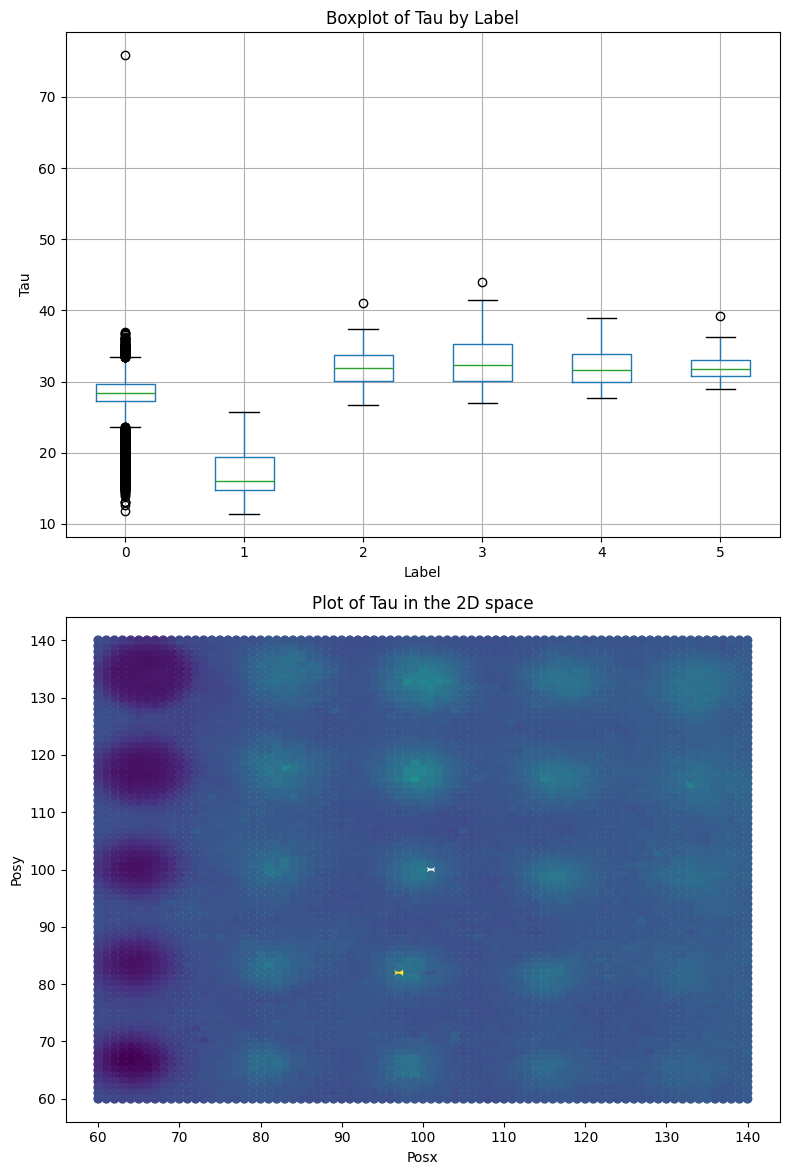

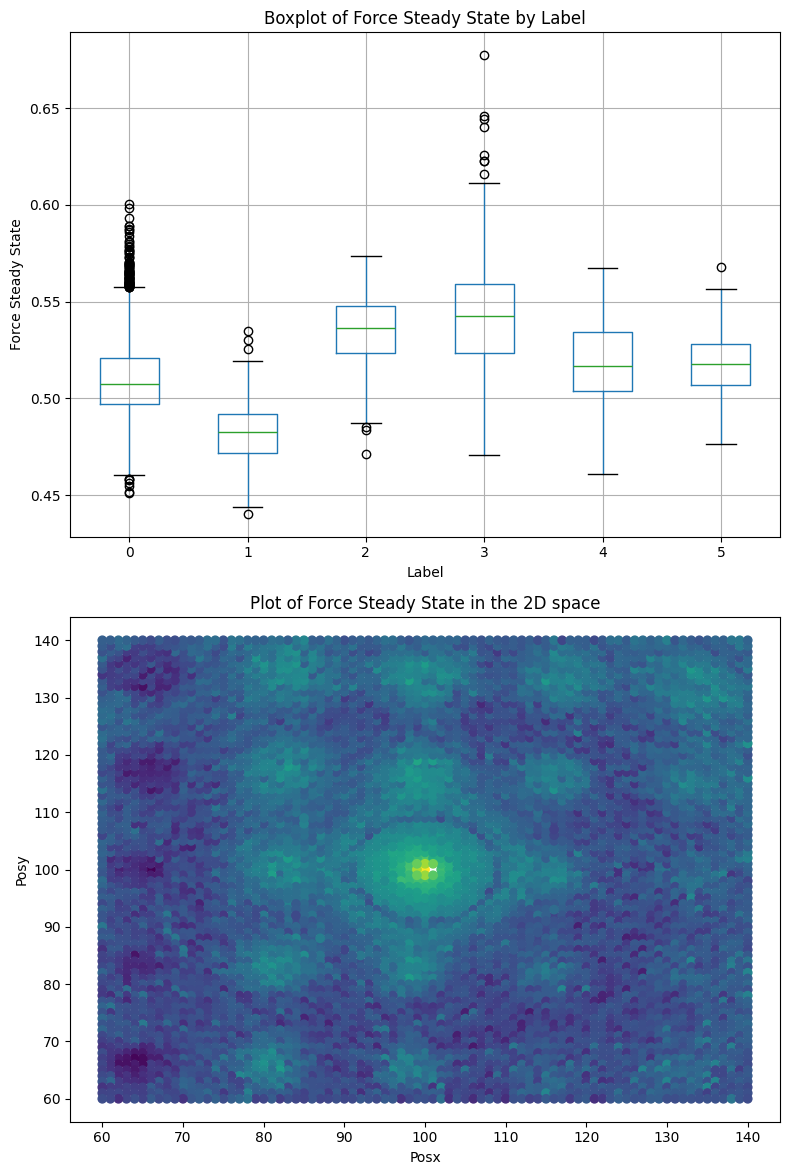

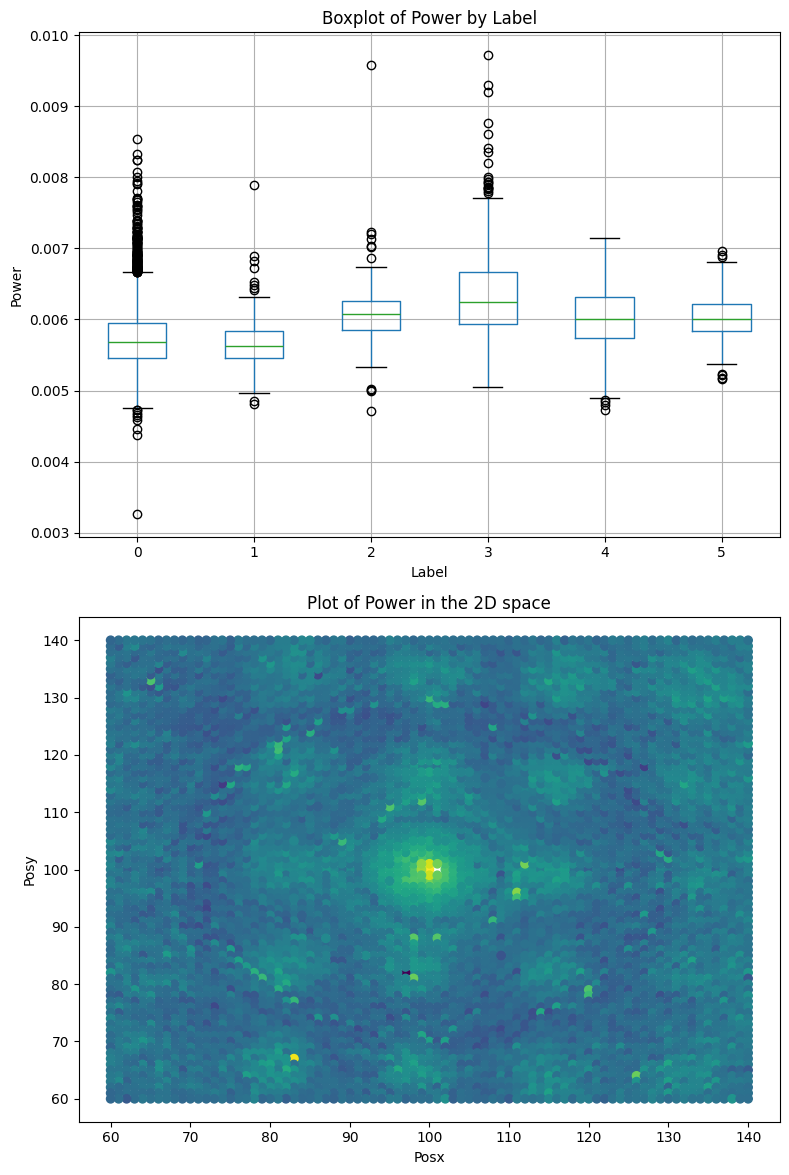

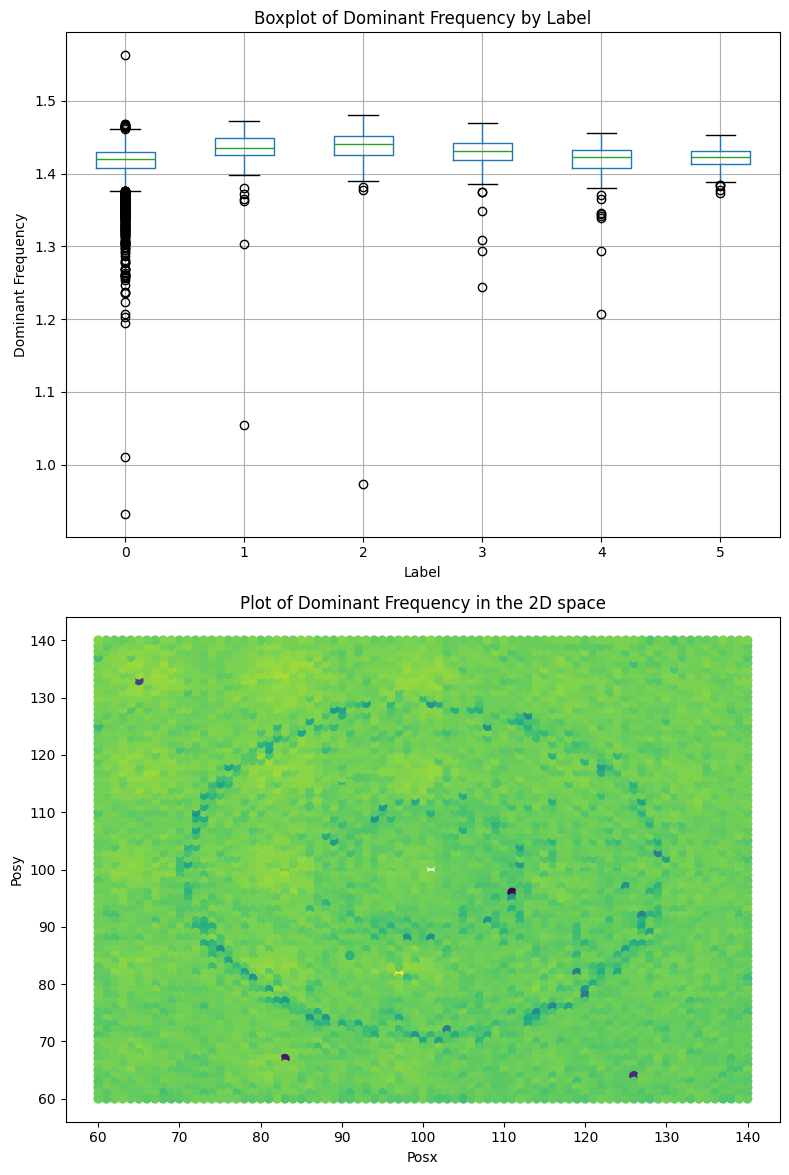

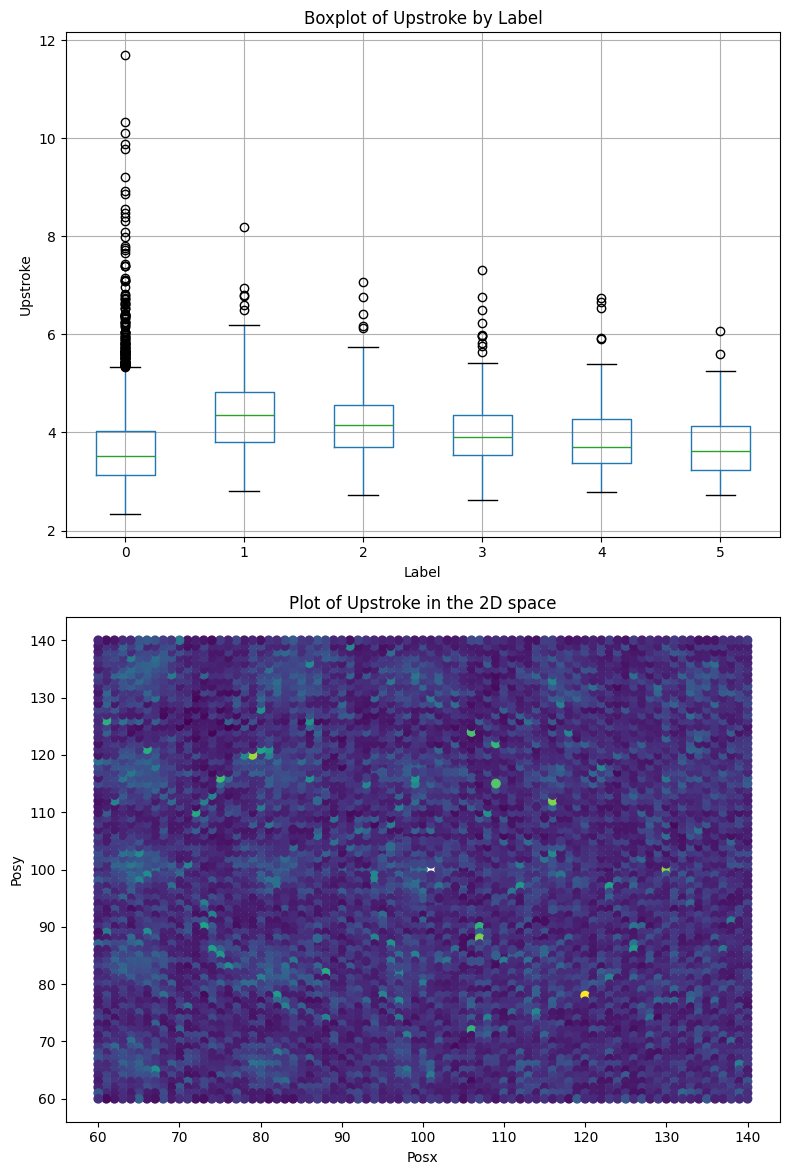

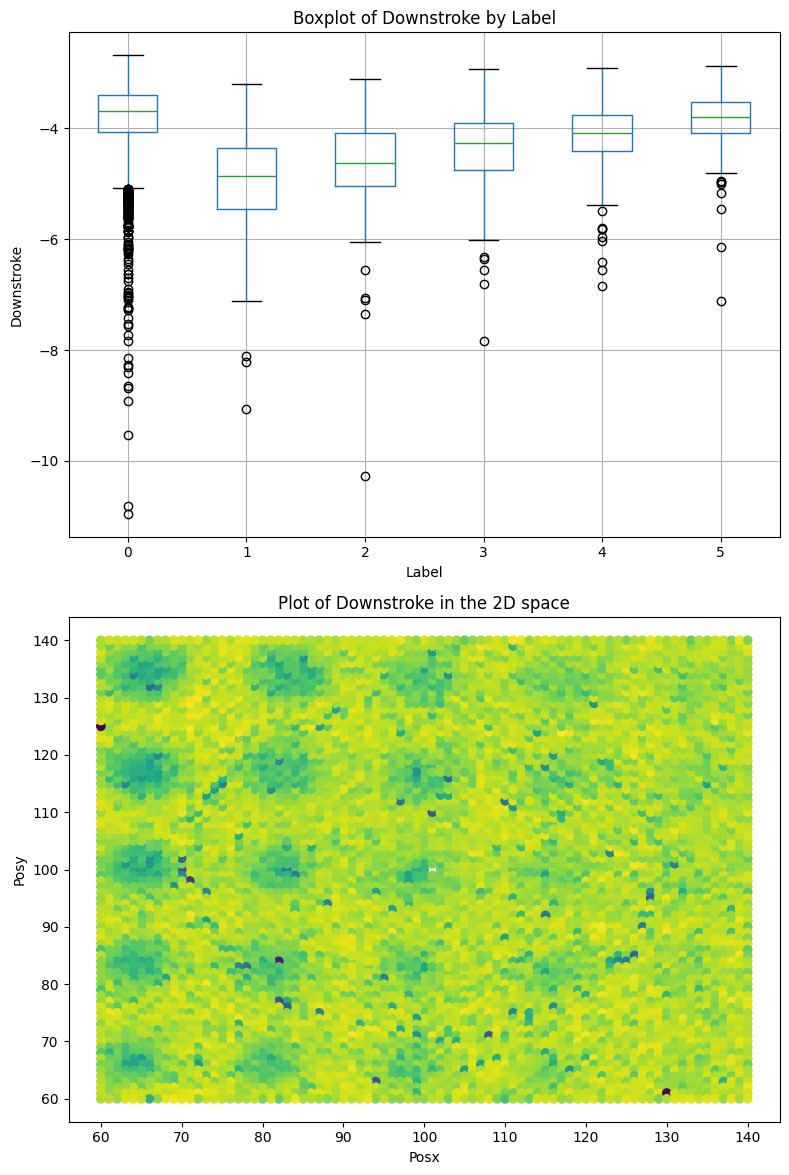

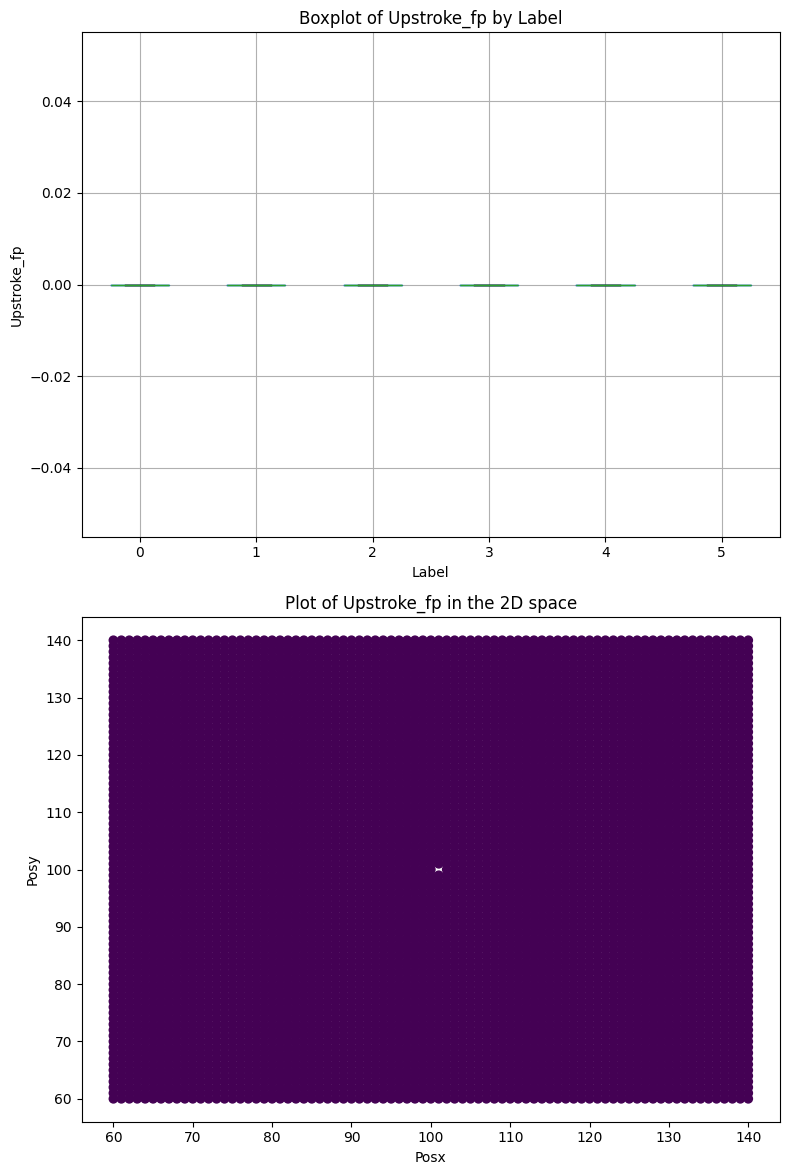

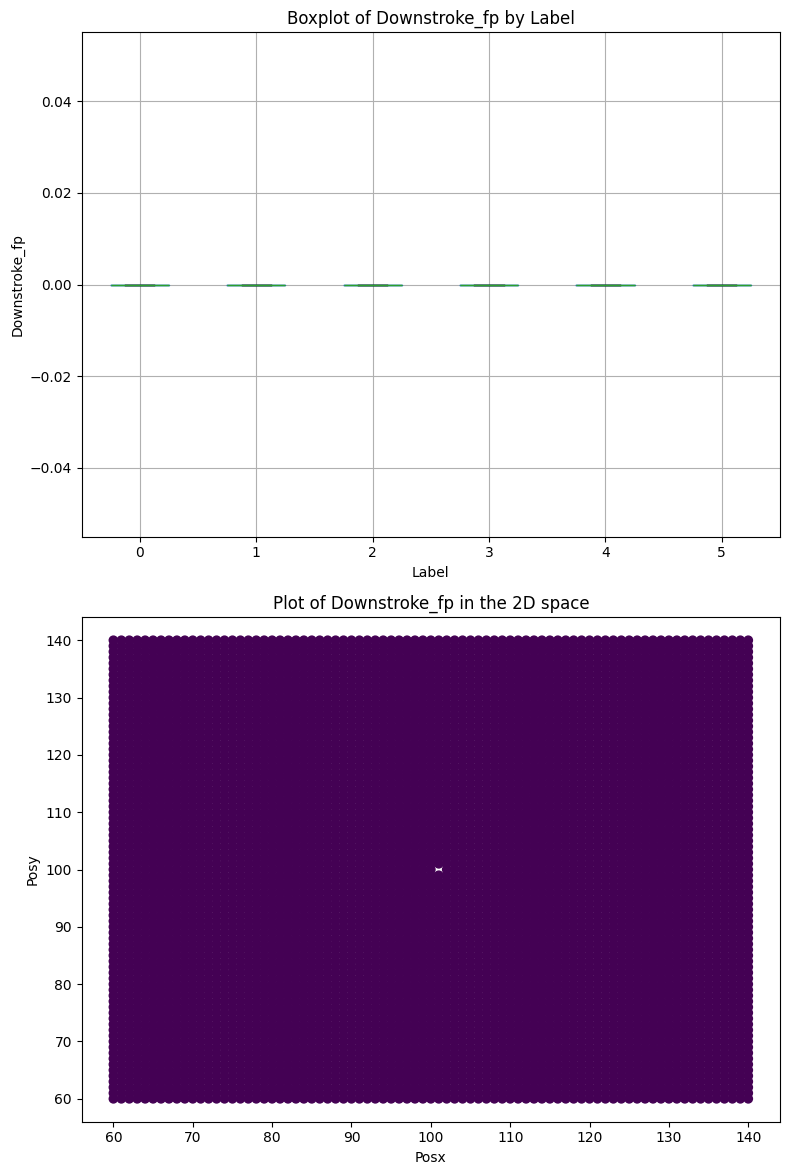

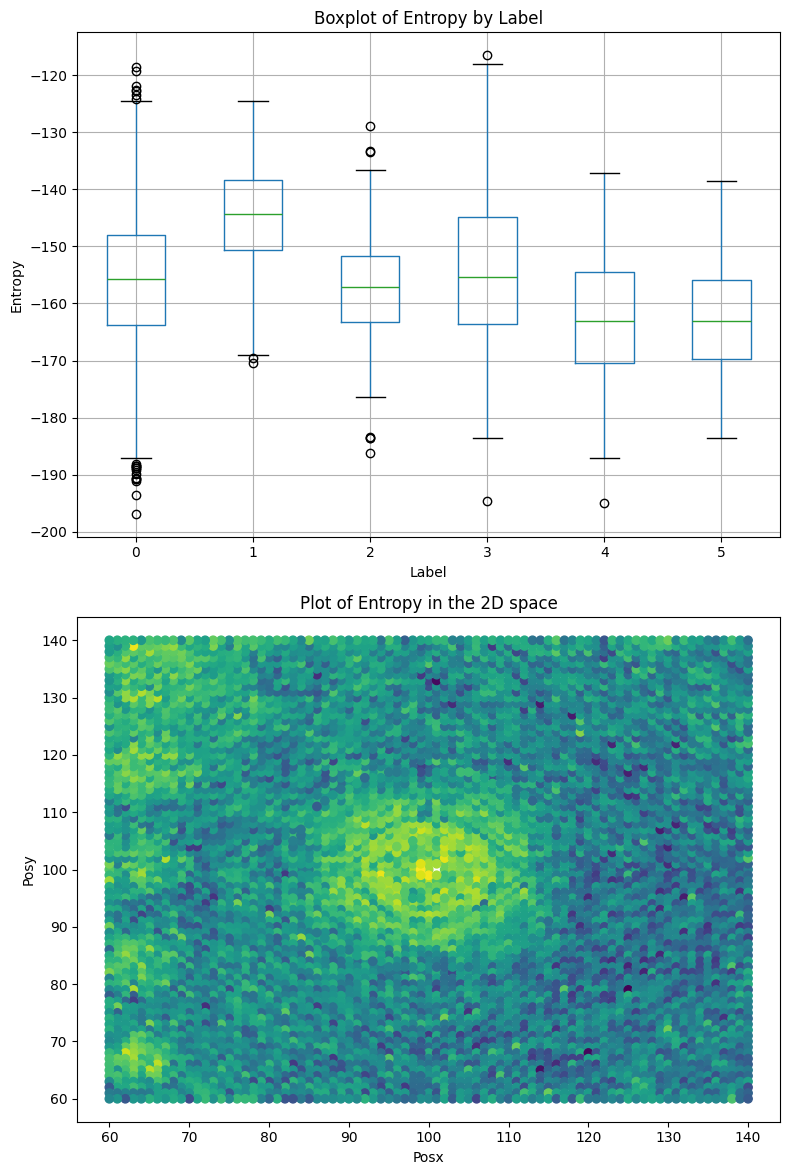

In [6]:
feature_list= ['Stiffness','Stiffness2','Tau','Force Steady State','Power','Dominant Frequency','Upstroke','Downstroke','Upstroke_fp','Downstroke_fp','Entropy']  # Define the features name

for feature in feature_list:
    fig, axes = plt.subplots(2, 1, figsize=(8, 12))  # Create subplots (3 rows, 1 column)

    # Box plot (Feature distribution per Label)
    data.boxplot(column=feature, by="label", ax=axes[0], grid=True)
    axes[0].set_title(f"Boxplot of {feature} by Label")
    axes[0].set_xlabel("Label")
    axes[0].set_ylabel(feature)

    # Scatter plot with color based on label
    axes[1].scatter(data["posx"], data["posy"], c=data[feature], cmap="viridis")
    axes[1].set_xlabel("Posx")
    axes[1].set_ylabel("Posy")
    axes[1].set_title(f"Plot of {feature} in the 2D space")

    # Adjust layout and remove default Matplotlib boxplot title
    plt.suptitle("")  # Remove default title generated by `boxplot`
    plt.tight_layout()  # Prevent overlap
    plt.show()

Appendix: estimation of the sampling frequency + jitter

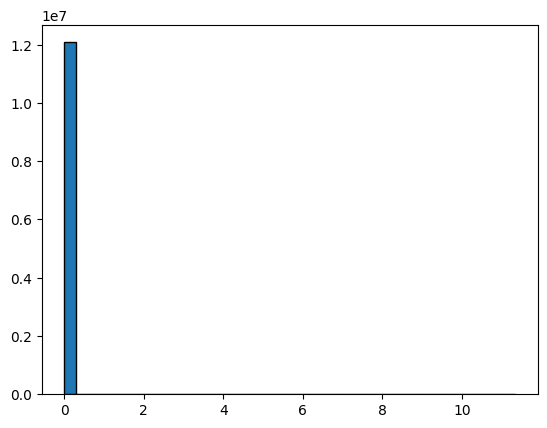

The sampling frequency is ~ 326.84985411852153 Hz
The jitter is ~ 0.0035192260965166773 Hz


In [7]:
delta_t = list()
for time in data['t'].tolist():
    delta_t.extend(np.diff(time))
plt.hist(delta_t, bins = 40, edgecolor='black')
plt.show()

f_mean = 1/np.mean(delta_t)
print(f'The sampling frequency is ~ {f_mean} Hz')

jitter = np.std(delta_t)
print(f'The jitter is ~ {jitter} Hz')

Test on Izhikevich neuron response

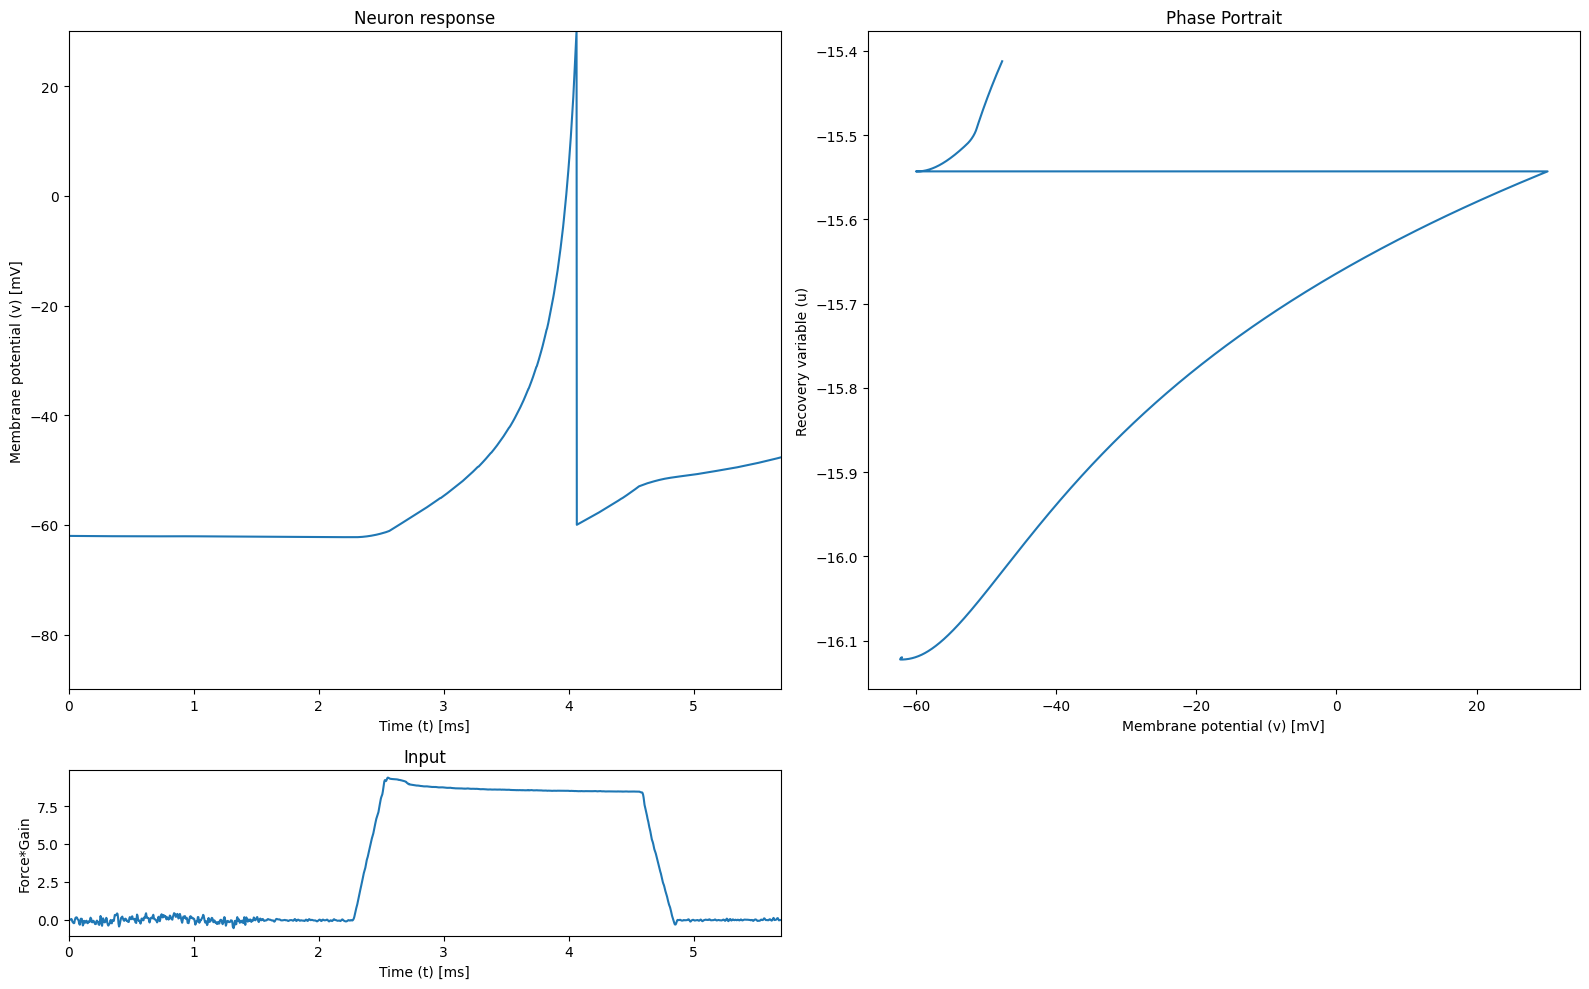

In [8]:
from Izhikevich import simulate_neuron #DEVO CAMBIARE LA SCALA TEMPORALE :)
gain = 8
input_f =np.multiply(df['Fz_s'].to_numpy()[0], gain)
time = df['t'].tolist()[0]
dt = np.mean(np.diff(time))
v,u = simulate_neuron(0.05,0.26,-60,0,-62,0.26*-62,dt,time,input_f)

fig = plt.figure(figsize=(16, 10))

# Time vs. Membrane Potential Plot
ax1 = plt.subplot2grid((4, 4), (0, 0), colspan=2, rowspan=3)
ax1.plot(time, v)
ax1.set_title('Neuron response')
ax1.set_xlim(0, max(time))
ax1.set_ylim(-90, 30)  # See note below
ax1.set_xlabel("Time (t) [ms]")
ax1.set_ylabel("Membrane potential (v) [mV]")

# Phase Portrait Plot
ax2 = plt.subplot2grid((4, 4), (0, 2), colspan=2, rowspan=3)
ax2.plot(v, u)
ax2.set_title('Phase Portrait')
ax2.set_xlabel("Membrane potential (v) [mV]")
ax2.set_ylabel("Recovery variable (u)")

# Input Current Plot
ax3 = plt.subplot2grid((4, 4), (3, 0), colspan=2, rowspan=1)
ax3.plot(time, input_f)
ax3.set_xlim(0, max(time))
ax3.set_title("Input")
ax3.set_xlabel("Time (t) [ms]")
ax3.set_ylabel("Force*Gain")

# Adjust layout and plot
plt.tight_layout()
plt.show()
